In [ ]:
# visualization paramters
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from sklearn import metrics
import matplotlib as mpl

# --- Research Article Style Settings ---
mpl.rcParams['font.family'] = 'Arial'
sns.set_style("white")
mpl.rcParams['axes.linewidth'] = 1.5  # Set axis line width
mpl.rcParams['axes.edgecolor'] = 'black'  # Set the edge color of the axes
mpl.rcParams['xtick.major.size'] = 6
mpl.rcParams['ytick.major.size'] = 6
mpl.rcParams['xtick.major.width'] = 2
mpl.rcParams['ytick.major.width'] = 2
mpl.rcParams['xtick.color'] = 'black'
mpl.rcParams['ytick.color'] = 'black'
mpl.rcParams['font.size'] = 16
mpl.rcParams['legend.fontsize'] = 10
mpl.rcParams['figure.dpi'] = 1200  # High resolution for publications
mpl.rcParams['xtick.labelsize'] = 14  # Increased x-tick label font size
mpl.rcParams['ytick.labelsize'] = 14  # Increased y-tick label font size


# # if we waant default parameters
# import matplotlib as mpl
# mpl.rcParams.update(mpl.rcParamsDefault)

In [ ]:

# ----------------- 1. Imports -----------------
import os
import joblib
import pickle
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PowerTransformer, MinMaxScaler, LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.metrics import r2_score, mean_squared_error

from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor

from category_encoders import TargetEncoder

import xgboost as xgb
import lightgbm as lgb
import shap

from tabpfn import TabPFNClassifier, TabPFNRegressor  # Import TabPFN


# ----------------- 2. Load dataset and drop 'Sr' -----------------
file_path = 'dataset.xlsx'
sheet_name = 'Sheet1'
df = pd.read_excel(file_path, sheet_name=sheet_name)
df = df.drop(columns=['Sr'])

# ----------------- 3. Define features and target -----------------
X = df.drop('k', axis=1)
y = df['k']

# ----------------- 4. Train-test split -----------------
X_train, X_test, y_train_raw, y_test_raw = train_test_split(X, y, test_size=0.2, random_state=40)

# ----------------- 5. Label Encoding 'Dope' and 'GS' -----------------
le_dope = LabelEncoder()
le_gs = LabelEncoder()

X_train['Dope'] = le_dope.fit_transform(X_train['Dope'])
X_test['Dope'] = le_dope.transform(X_test['Dope'])

X_train['GS'] = le_gs.fit_transform(X_train['GS'])
X_test['GS'] = le_gs.transform(X_test['GS'])

# ----------------- 6. Target Encoding for 'PFRs' -----------------
target_encoder = TargetEncoder(cols=['PFRs'])
X_train = target_encoder.fit_transform(X_train, y_train_raw)
X_test = target_encoder.transform(X_test)

# ----------------- 7. Yeo-Johnson Transform for numeric features -----------------
numerical_features = ['SSA', 'APS', 'TPV', 'IdIg', 'PT', 'C', 'H', 'O', 'N', 'pH', 'Oxi-C', 'Bc-C', 'Pol-C']
power_transformer = PowerTransformer(method='yeo-johnson')
X_train[numerical_features] = power_transformer.fit_transform(X_train[numerical_features])
X_test[numerical_features] = power_transformer.transform(X_test[numerical_features])

# ----------------- 8. MinMax Scaling -----------------
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=X_train.columns, index=X_train.index)
X_test_scaled_df = pd.DataFrame(X_test_scaled, columns=X_test.columns, index=X_test.index)

# ----------------- 9. Yeo-Johnson Transform on target -----------------
y_pt = PowerTransformer(method='yeo-johnson')
y_train_transformed = y_pt.fit_transform(y_train_raw.values.reshape(-1, 1)).ravel()
y_test_transformed = y_pt.transform(y_test_raw.values.reshape(-1, 1)).ravel()

# ----------------- 10. Train Model -----------------
rf_model = RandomForestRegressor(random_state=42)
rf_model.fit(X_train_scaled_df, y_train_transformed)

# ----------------- 11. Prediction -----------------
y_train_pred_transformed = rf_model.predict(X_train_scaled_df)
y_test_pred_transformed = rf_model.predict(X_test_scaled_df)

# ----------------- 12. Inverse Transform Predictions -----------------
y_train_pred = y_pt.inverse_transform(y_train_pred_transformed.reshape(-1, 1)).ravel()
y_test_pred = y_pt.inverse_transform(y_test_pred_transformed.reshape(-1, 1)).ravel()

# ----------------- 13. Evaluation -----------------
train_r2 = r2_score(y_train_raw, y_train_pred)
test_r2 = r2_score(y_test_raw, y_test_pred)
train_rmse = np.sqrt(mean_squared_error(y_train_raw, y_train_pred))
test_rmse = np.sqrt(mean_squared_error(y_test_raw, y_test_pred))

print("\n--- Random Forest Performance ---")
print(f"Train R2: {train_r2:.4f}")
print(f"Test R2: {test_r2:.4f}")
print(f"Train RMSE: {train_rmse:.4f}")
print(f"Test RMSE: {test_rmse:.4f}")



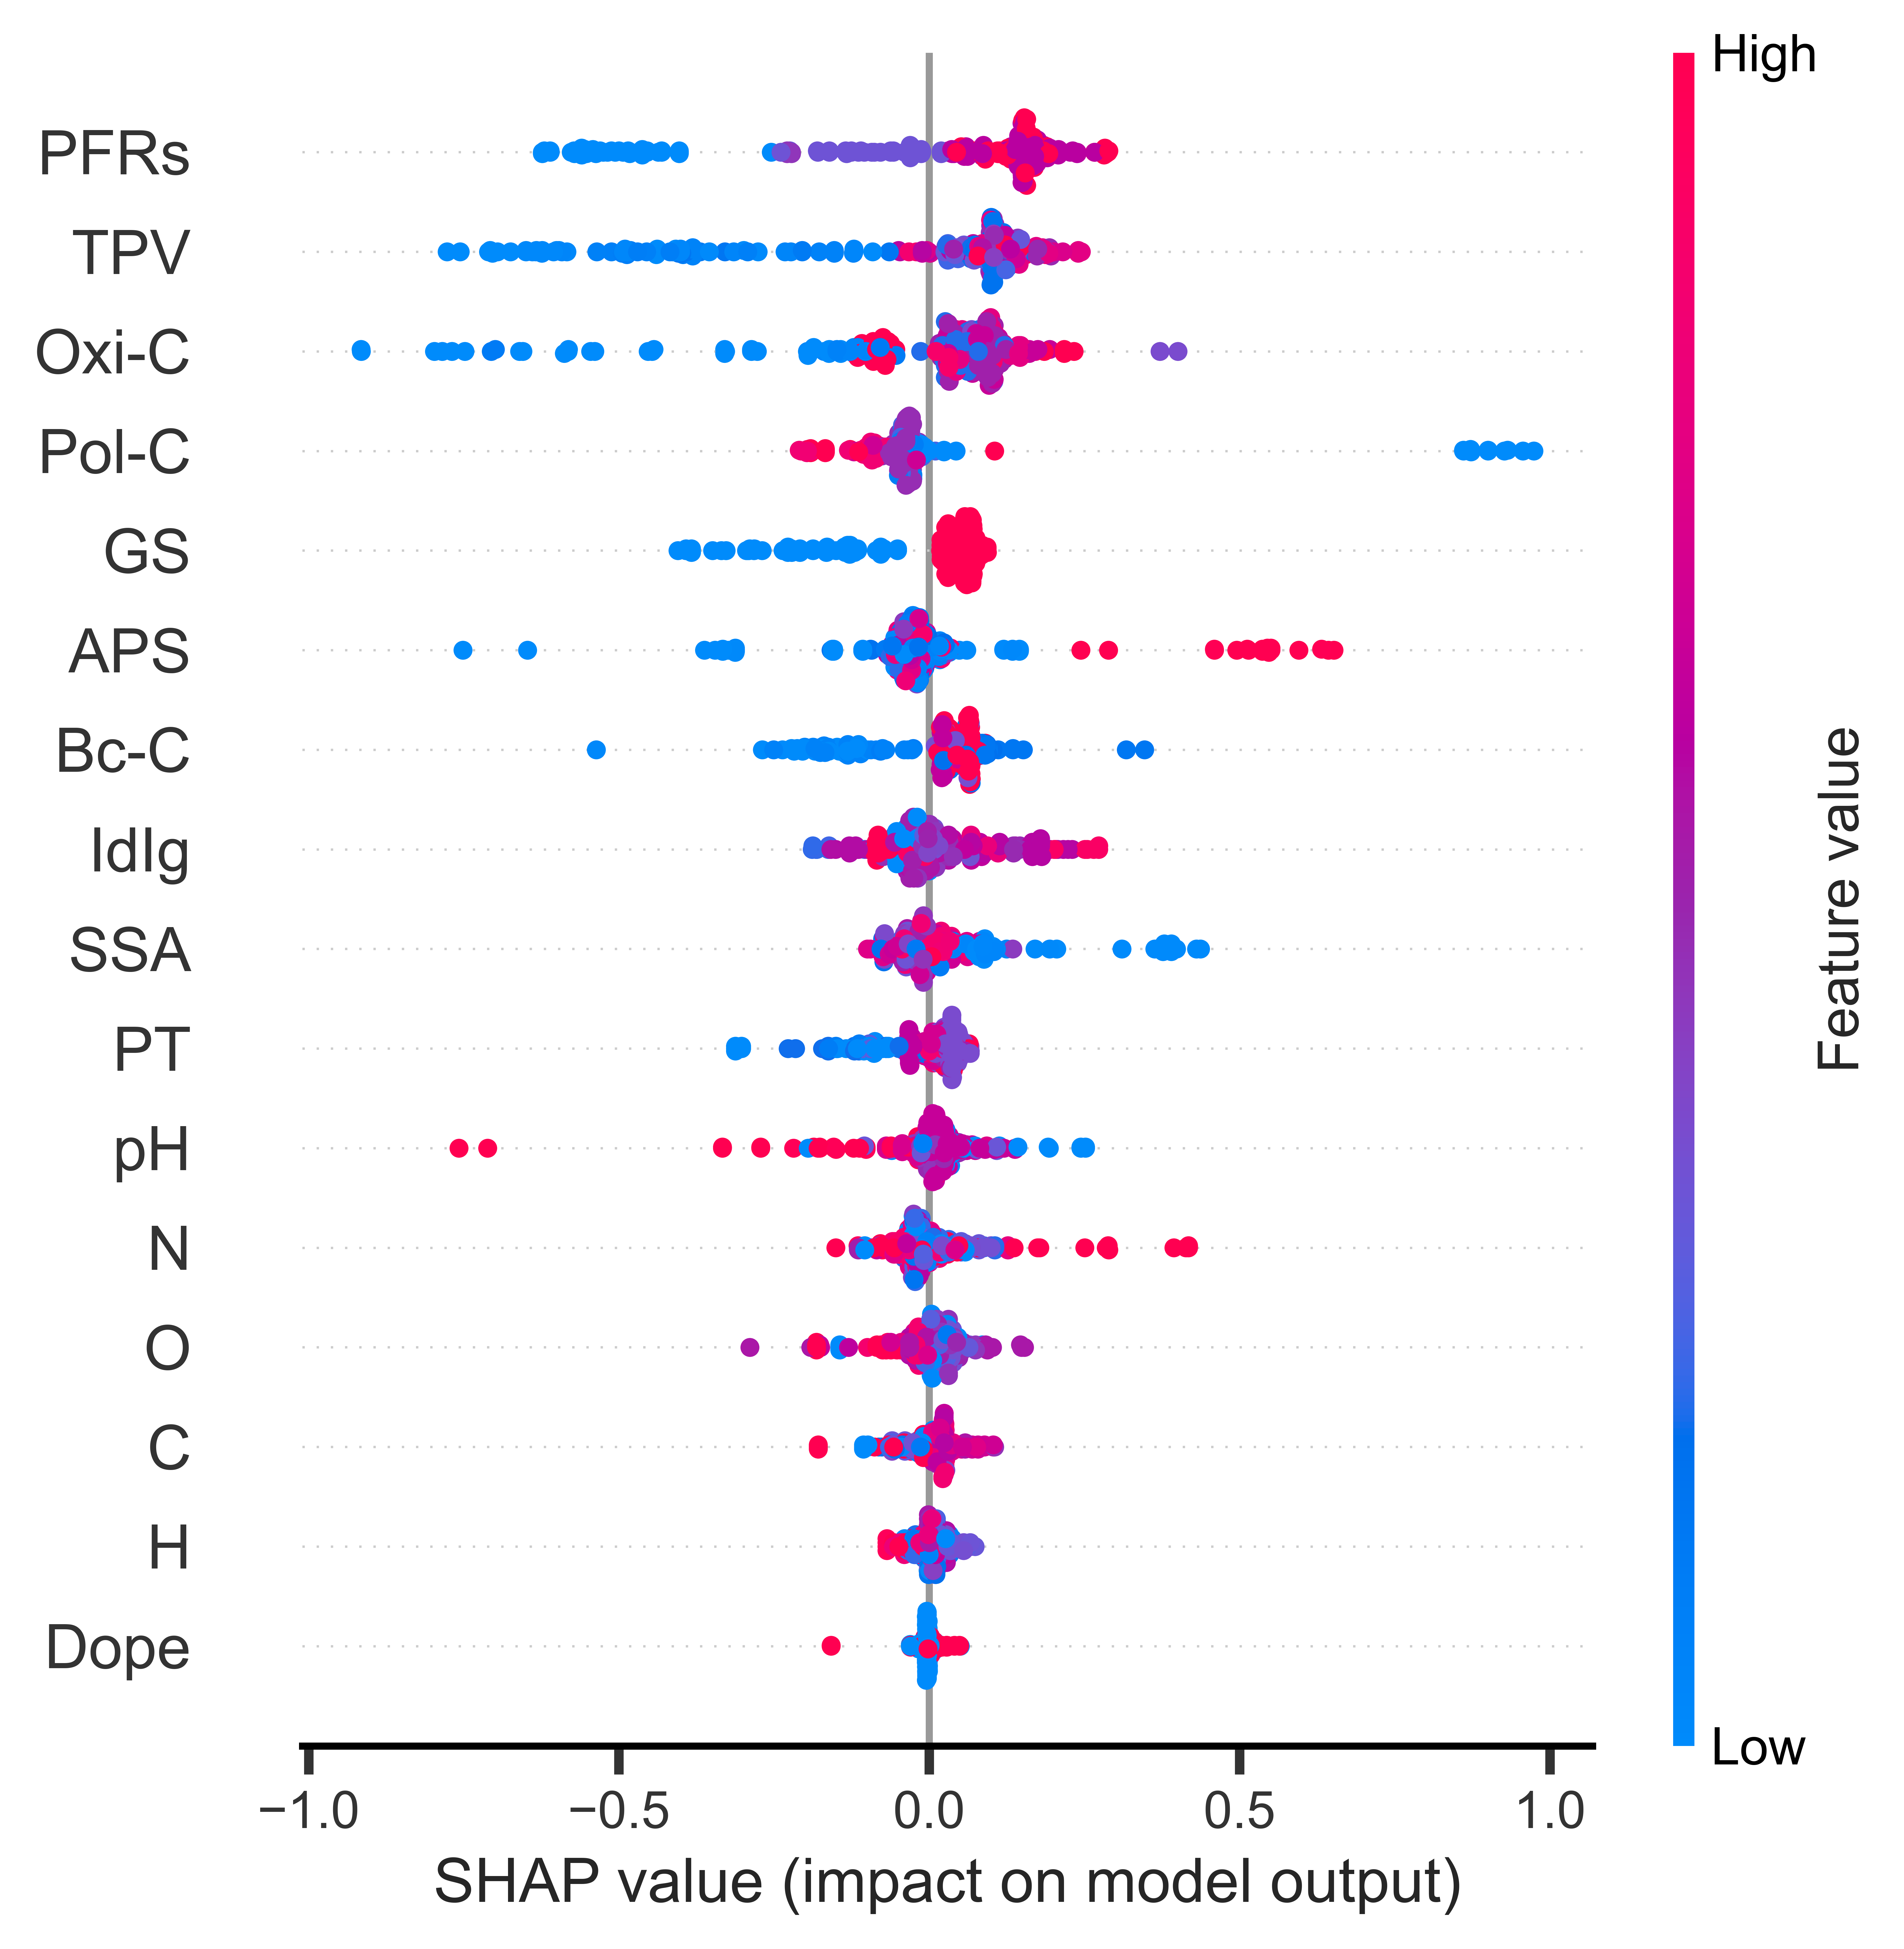

In [ ]:
# --- SHAP Initialization ---
explainer = shap.TreeExplainer(rf_model)
shap_values = explainer.shap_values(X_train_scaled_df)

# --- SHAP Summary Plot (Bee Swarm) ---
# shap.summary_plot(shap_values, X_train_scaled_df, plot_type='dot')

# --- SHAP Bar Plot (Feature Importance) ---
# shap.summary_plot(shap_values, X_train_scaled_df, plot_type='bar')

# # --- SHAP Bar Plot ---
explainerb = shap.Explainer(rf_model, X_train_scaled_df) 
shap_valuesb = explainer(X_train_scaled_df)


shap.plots.bar(shap_valuesb, max_display=16)

# --- Modify figure size and layout ---
shap.plots.beeswarm(shap_valuesb, max_display=16, show=False)
fig = plt.gcf()
fig.set_size_inches(6, 6)
plt.tight_layout()
plt.show()


<Figure size 7200x7200 with 0 Axes>

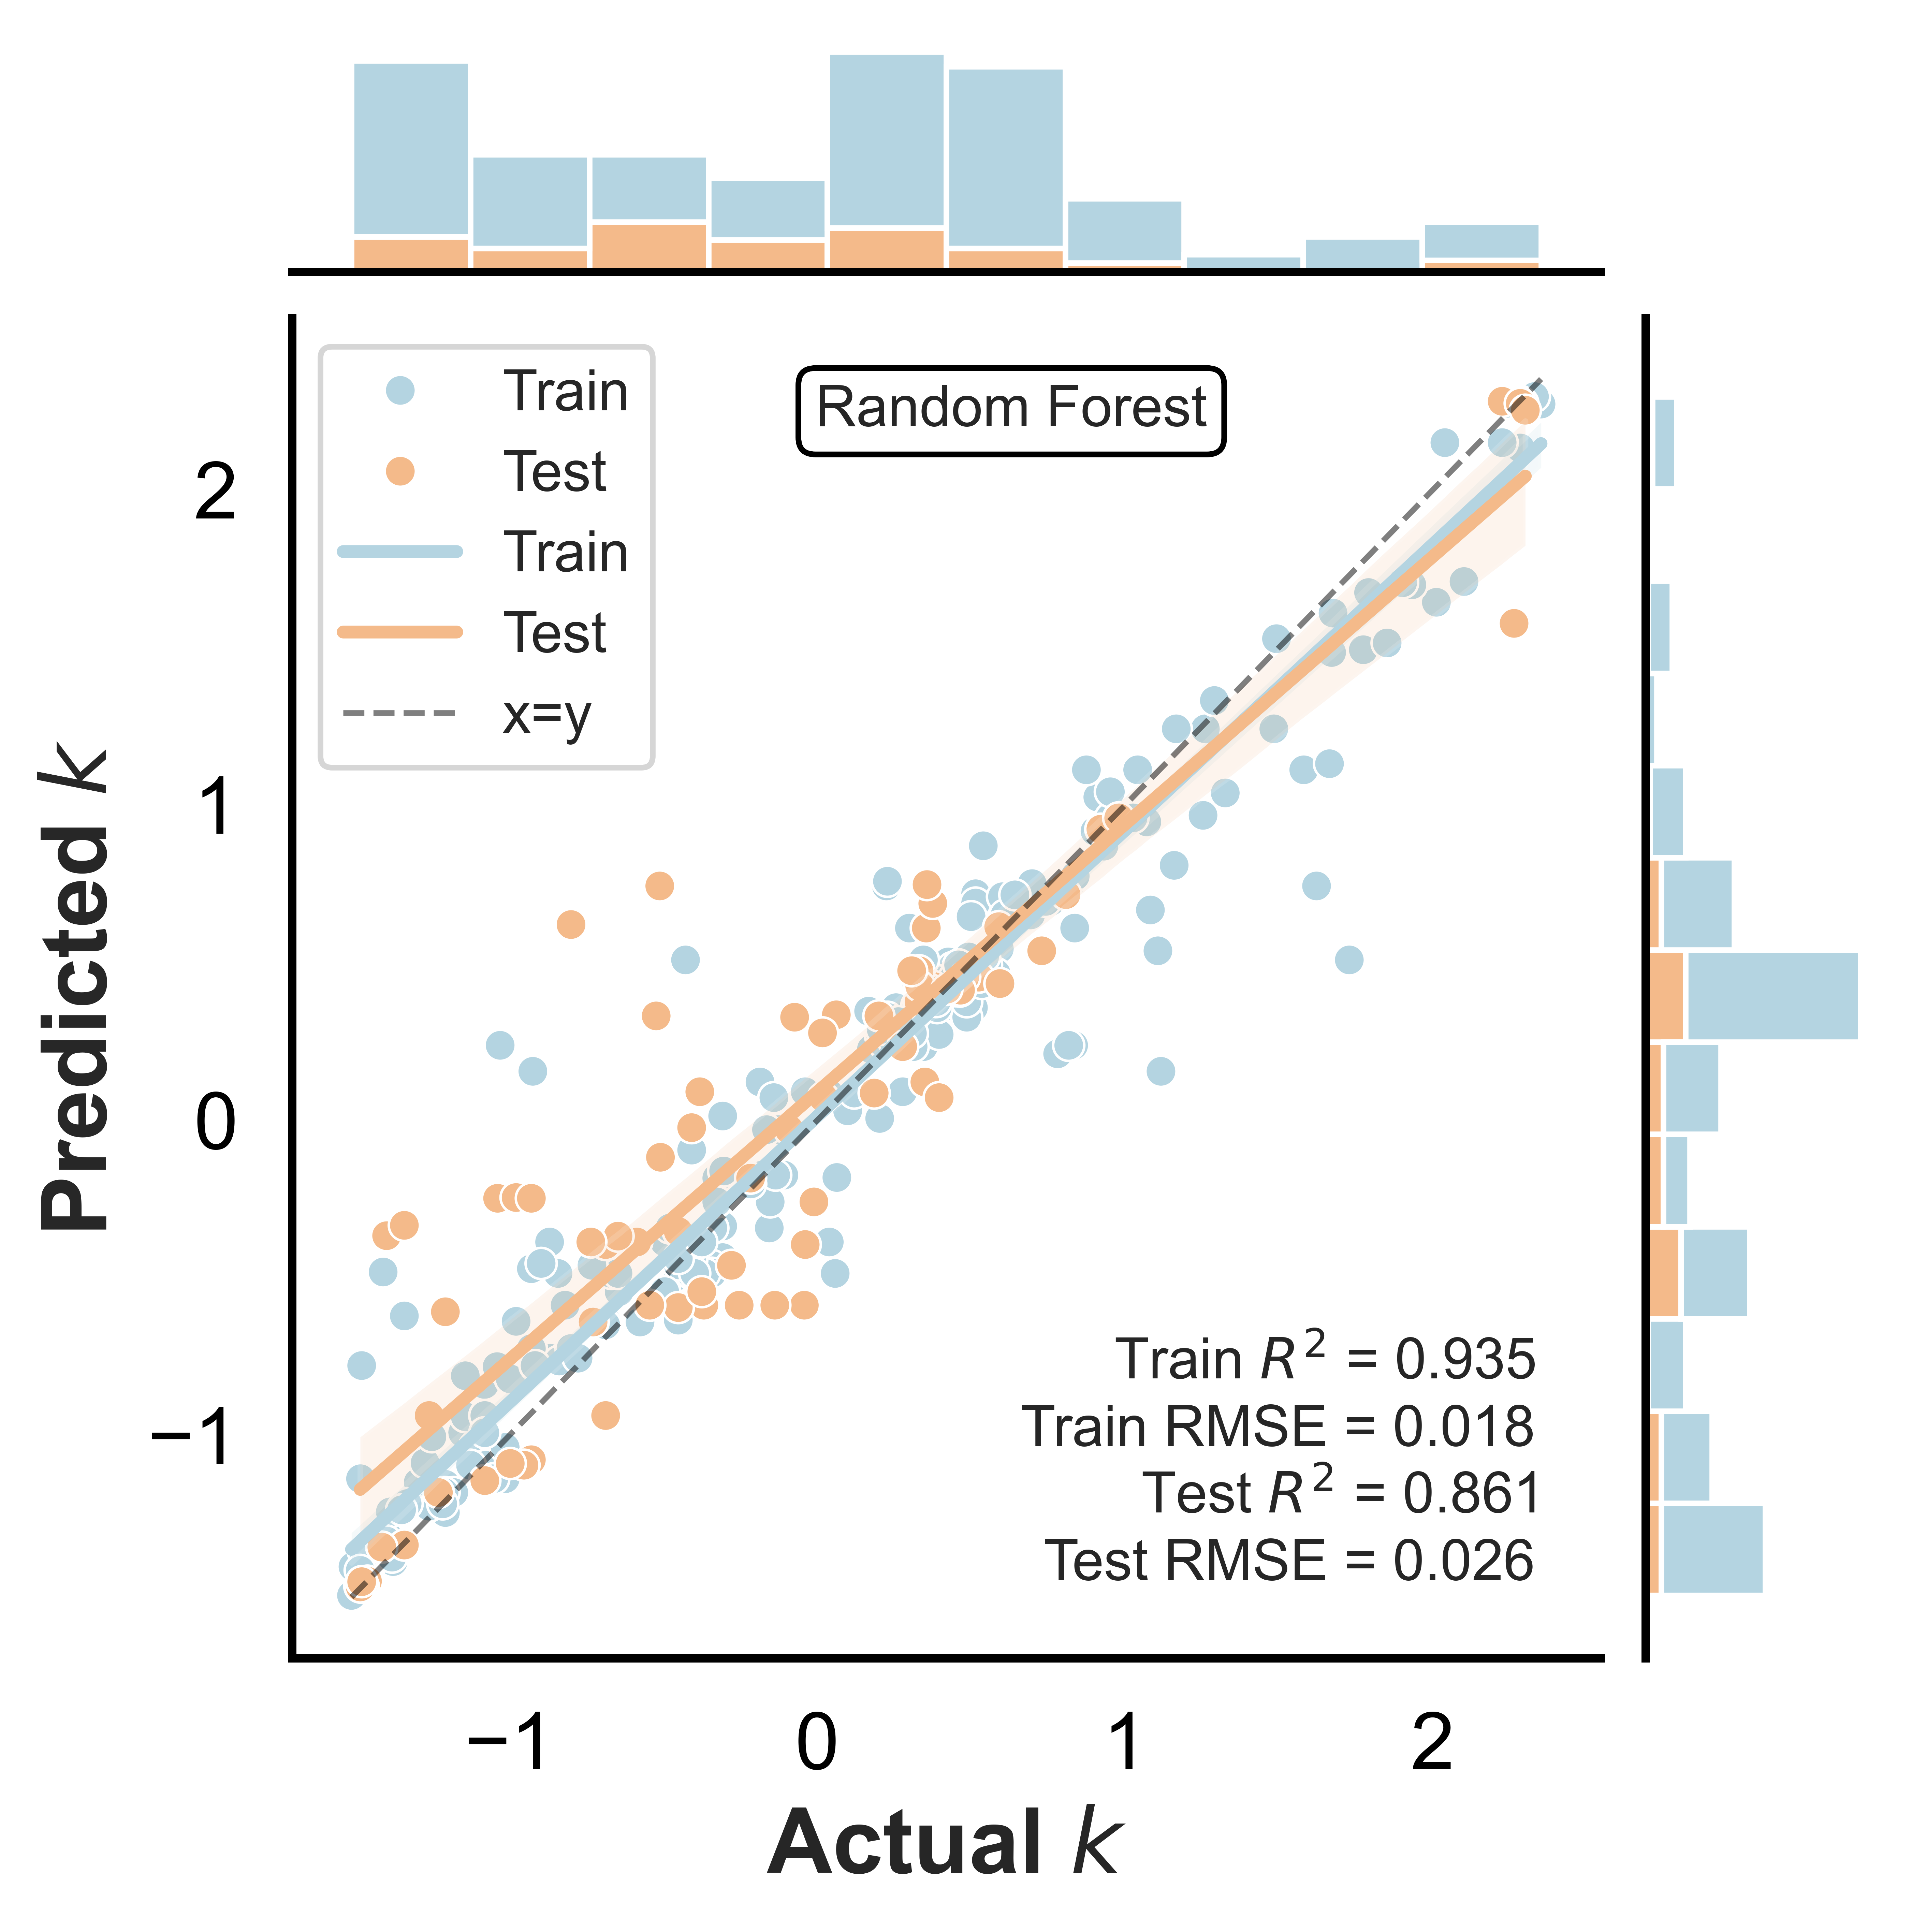

In [ ]:
# Create DataFrames for train and test sets (TRANSFORMED DATA)
data_train_transformed = pd.DataFrame({'True': y_train_transformed, 'Predicted': y_train_pred_transformed, 'Data Set': 'Train'})
data_test_transformed = pd.DataFrame({'True': y_test_transformed, 'Predicted': y_test_pred_transformed, 'Data Set': 'Test'})
data_transformed = pd.concat([data_train_transformed, data_test_transformed])

# Custom color palette
palette = {'Train': '#b4d4e1', 'Test': '#f4ba8a'}

# Create JointGrid
plt.figure(figsize=(6, 6))  # Adjusted figure size
g = sns.JointGrid(data=data_transformed, x="True", y="Predicted", hue="Data Set", height=5, palette=palette)  # Adjusted height

# Plot scatter plot
g.plot_joint(sns.scatterplot, alpha=1, s=30)  # Adjusted alpha and size of points

# Add regression lines
sns.regplot(data=data_train_transformed, x="True", y="Predicted", scatter=False, ax=g.ax_joint, color='#b4d4e1', label='Train')
sns.regplot(data=data_test_transformed, x="True", y="Predicted", scatter=False, ax=g.ax_joint, color='#f4ba8a', label='Test')

# Add marginal histograms
g.plot_marginals(sns.histplot, kde=False, element='bars', multiple='stack', alpha=1)

# Add evaluation metrics text
ax = g.ax_joint
ax.text(0.95, 0.20, f'Train $R^2$ = {train_r2:.3f}', transform=ax.transAxes, fontsize=10,
        verticalalignment='bottom', horizontalalignment='right')
ax.text(0.95, 0.15, f'Train RMSE = {train_rmse:.3f}', transform=ax.transAxes, fontsize=10,
        verticalalignment='bottom', horizontalalignment='right')
ax.text(0.95, 0.10, f'Test $R^2$ = {test_r2:.3f}', transform=ax.transAxes, fontsize=10,
        verticalalignment='bottom', horizontalalignment='right')
ax.text(0.95, 0.05, f'Test RMSE = {test_rmse:.3f}', transform=ax.transAxes, fontsize=10,
        verticalalignment='bottom', horizontalalignment='right')

# Add model name text
ax.text(0.4, 0.95, 'Random Forest', transform=ax.transAxes, fontsize=10, # change model name
        verticalalignment='top', horizontalalignment='left', bbox=dict(boxstyle="round,pad=0.3", edgecolor="black", facecolor="white"))

# Add central line
ax.plot([data_transformed['True'].min(), data_transformed['True'].max()],
        [data_transformed['True'].min(), data_transformed['True'].max()], c="black", alpha=0.5, linestyle='--', linewidth=1, label='x=y')
ax.legend(loc='upper left')

# Set axis labels with increased font size and bold
ax.set_xlabel('Actual $k$', fontsize=16, fontweight='bold')
ax.set_ylabel('Predicted $k$', fontsize=16, fontweight='bold')

# Remove top and right spines for a cleaner look
sns.despine(ax=ax)

# Save and show the plot
# plt.savefig("TrueFalse_RF_Transformed_Article_Metrics.png", format='png', bbox_inches='tight', dpi=300) # Saving as PNG for better compatibility
plt.show()

In [ ]:
#1  RF default
# ----------------- 10. Train Model -----------------
rf_model = RandomForestRegressor(random_state=42)
rf_model.fit(X_train_scaled_df, y_train_transformed)

# ----------------- 11. Prediction -----------------
y_train_pred_transformed = rf_model.predict(X_train_scaled_df)
y_test_pred_transformed = rf_model.predict(X_test_scaled_df)

# ----------------- 12. Inverse Transform Predictions -----------------
y_train_pred = y_pt.inverse_transform(y_train_pred_transformed.reshape(-1, 1)).ravel()
y_test_pred = y_pt.inverse_transform(y_test_pred_transformed.reshape(-1, 1)).ravel()

# ----------------- 13. Evaluation -----------------
train_r2 = r2_score(y_train_raw, y_train_pred)
test_r2 = r2_score(y_test_raw, y_test_pred)
train_rmse = np.sqrt(mean_squared_error(y_train_raw, y_train_pred))
test_rmse = np.sqrt(mean_squared_error(y_test_raw, y_test_pred))

print("\n--- Random Forest Performance ---")
print(f"Train R2: {train_r2:.4f}")
print(f"Test R2: {test_r2:.4f}")
print(f"Train RMSE: {train_rmse:.4f}")
print(f"Test RMSE: {test_rmse:.4f}")


In [ ]:
#1  RF hyperparameters and CV
# ----------------- 10. Train Model and CV and Tunning  -----------------

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import r2_score, mean_squared_error
import numpy as np

# ----------------- 10. Hyperparameter Tuning with CV -----------------
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'max_features': ['auto', 'sqrt']
}

rf = RandomForestRegressor(random_state=42)
grid_search = GridSearchCV(rf, param_grid, cv=7, n_jobs=-1, scoring='r2', verbose=1)
grid_search.fit(X_train_scaled_df, y_train_transformed)

best_rf_model = grid_search.best_estimator_

# ----------------- 11. Prediction -----------------
y_train_pred_transformed = best_rf_model.predict(X_train_scaled_df)
y_test_pred_transformed = best_rf_model.predict(X_test_scaled_df)

# ----------------- 12. Inverse Transform Predictions -----------------
y_train_pred = y_pt.inverse_transform(y_train_pred_transformed.reshape(-1, 1)).ravel()
y_test_pred = y_pt.inverse_transform(y_test_pred_transformed.reshape(-1, 1)).ravel()

# ----------------- 13. Evaluation -----------------
train_r2 = r2_score(y_train_raw, y_train_pred)
test_r2 = r2_score(y_test_raw, y_test_pred)
train_rmse = np.sqrt(mean_squared_error(y_train_raw, y_train_pred))
test_rmse = np.sqrt(mean_squared_error(y_test_raw, y_test_pred))

print("\n--- Tuned Random Forest Performance ---")
print("Best Parameters:", grid_search.best_params_)
print(f"Train R2: {train_r2:.4f}")
print(f"Test R2: {test_r2:.4f}")
print(f"Train RMSE: {train_rmse:.4f}")
print(f"Test RMSE: {test_rmse:.4f}")


In [ ]:

#2 XGB default
# ----------------- 10. Train Model -----------------
xgb_model = xgb.XGBRegressor(random_state=42)
xgb_model.fit(X_train_scaled_df, y_train_transformed)

# ----------------- 11. Prediction -----------------
y_train_pred_transformed = xgb_model.predict(X_train_scaled_df)
y_test_pred_transformed = xgb_model.predict(X_test_scaled_df)

# ----------------- 12. Inverse Transform Predictions -----------------
y_train_pred = y_pt.inverse_transform(y_train_pred_transformed.reshape(-1, 1)).ravel()
y_test_pred = y_pt.inverse_transform(y_test_pred_transformed.reshape(-1, 1)).ravel()

# ----------------- 13. Evaluation -----------------
train_r2 = r2_score(y_train_raw, y_train_pred)
test_r2 = r2_score(y_test_raw, y_test_pred)
train_rmse = np.sqrt(mean_squared_error(y_train_raw, y_train_pred))
test_rmse = np.sqrt(mean_squared_error(y_test_raw, y_test_pred))

print("\n--- XGB ---")
print(f"Train R2: {train_r2:.4f}")
print(f"Test R2: {test_r2:.4f}")
print(f"Train RMSE: {train_rmse:.4f}")
print(f"Test RMSE: {test_rmse:.4f}")



In [ ]:
#2 XGB hyperparameters and CV
from sklearn.model_selection import GridSearchCV
import xgboost as xgb
import numpy as np
from sklearn.metrics import r2_score, mean_squared_error

# ----------------- Define Parameter Grid -----------------
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.05, 0.1],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0],
    'reg_alpha': [0, 0.1, 1],
    'reg_lambda': [1, 5, 10]
}

# ----------------- Initialize XGB Regressor -----------------
xgb_model = xgb.XGBRegressor(random_state=42)

# ----------------- Grid Search with 5-Fold CV -----------------
grid_search = GridSearchCV(
    estimator=xgb_model,
    param_grid=param_grid,
    scoring='r2',
    cv=7,
    n_jobs=-1,
    verbose=2
)

grid_search.fit(X_train_scaled_df, y_train_transformed)

# ----------------- Best Model -----------------
best_model = grid_search.best_estimator_
print("Best Parameters:", grid_search.best_params_)

# ----------------- Predictions -----------------
y_train_pred_transformed = best_model.predict(X_train_scaled_df)
y_test_pred_transformed = best_model.predict(X_test_scaled_df)

# ----------------- Inverse Transform -----------------
y_train_pred = y_pt.inverse_transform(y_train_pred_transformed.reshape(-1, 1)).ravel()
y_test_pred = y_pt.inverse_transform(y_test_pred_transformed.reshape(-1, 1)).ravel()

# ----------------- Evaluation -----------------
train_r2 = r2_score(y_train_raw, y_train_pred)
test_r2 = r2_score(y_test_raw, y_test_pred)
train_rmse = np.sqrt(mean_squared_error(y_train_raw, y_train_pred))
test_rmse = np.sqrt(mean_squared_error(y_test_raw, y_test_pred))

print("\n--- Tuned XGB ---")
print(f"Train R2: {train_r2:.4f}")
print(f"Test R2: {test_r2:.4f}")
print(f"Train RMSE: {train_rmse:.4f}")
print(f"Test RMSE: {test_rmse:.4f}")


Fitting 5 folds for each of 972 candidates, totalling 4860 fits
Best Parameters: {'colsample_bytree': 1.0, 'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 100, 'reg_alpha': 0, 'reg_lambda': 10, 'subsample': 1.0}

--- Tuned XGB ---
Train R2: 0.9248
Test R2: 0.8381
Train RMSE: 0.0190
Test RMSE: 0.0284


In [ ]:

#3 LGB default
# ----------------- 10. Train Model -----------------
lgb_model = lgb.LGBMRegressor(random_state=42)
lgb_model.fit(X_train_scaled_df, y_train_transformed)

# ----------------- 11. Prediction -----------------
y_train_pred_transformed = lgb_model.predict(X_train_scaled_df)
y_test_pred_transformed = lgb_model.predict(X_test_scaled_df)

# ----------------- 12. Inverse Transform Predictions -----------------
y_train_pred = y_pt.inverse_transform(y_train_pred_transformed.reshape(-1, 1)).ravel()
y_test_pred = y_pt.inverse_transform(y_test_pred_transformed.reshape(-1, 1)).ravel()

# ----------------- 13. Evaluation -----------------
train_r2 = r2_score(y_train_raw, y_train_pred)
test_r2 = r2_score(y_test_raw, y_test_pred)
train_rmse = np.sqrt(mean_squared_error(y_train_raw, y_train_pred))
test_rmse = np.sqrt(mean_squared_error(y_test_raw, y_test_pred))

print("\n--- LGB ---")
print(f"Train R2: {train_r2:.4f}")
print(f"Test R2: {test_r2:.4f}")
print(f"Train RMSE: {train_rmse:.4f}")
print(f"Test RMSE: {test_rmse:.4f}")



In [ ]:
# LGBM hyperparameters and CV
from sklearn.model_selection import GridSearchCV
import lightgbm as lgb
import numpy as np
from sklearn.metrics import r2_score, mean_squared_error

# ----------------- Define Parameter Grid -----------------
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [-1, 5, 10],
    'learning_rate': [0.01, 0.05, 0.1],
    'num_leaves': [31, 50, 100],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0],
    'reg_alpha': [0, 0.1, 1],
    'reg_lambda': [0, 1, 10]
}

# ----------------- Initialize LGBM Regressor -----------------
lgb_model = lgb.LGBMRegressor(random_state=42)

# ----------------- Grid Search with 5-Fold CV -----------------
grid_search = GridSearchCV(
    estimator=lgb_model,
    param_grid=param_grid,
    scoring='r2',
    cv=7,
    n_jobs=-1,
    verbose=2
)

grid_search.fit(X_train_scaled_df, y_train_transformed)

# ----------------- Best Model -----------------
best_model = grid_search.best_estimator_
print("Best Parameters:", grid_search.best_params_)

# ----------------- Predictions -----------------
y_train_pred_transformed = best_model.predict(X_train_scaled_df)
y_test_pred_transformed = best_model.predict(X_test_scaled_df)

# ----------------- Inverse Transform -----------------
y_train_pred = y_pt.inverse_transform(y_train_pred_transformed.reshape(-1, 1)).ravel()
y_test_pred = y_pt.inverse_transform(y_test_pred_transformed.reshape(-1, 1)).ravel()

# ----------------- Evaluation -----------------
train_r2 = r2_score(y_train_raw, y_train_pred)
test_r2 = r2_score(y_test_raw, y_test_pred)
train_rmse = np.sqrt(mean_squared_error(y_train_raw, y_train_pred))
test_rmse = np.sqrt(mean_squared_error(y_test_raw, y_test_pred))

print("\n--- Tuned LGB ---")
print(f"Train R2: {train_r2:.4f}")
print(f"Test R2: {test_r2:.4f}")
print(f"Train RMSE: {train_rmse:.4f}")
print(f"Test RMSE: {test_rmse:.4f}")


In [ ]:
            
#4 MLP
# ----------------- 10. Train Model -----------------
mlp_model = MLPRegressor(random_state=42, max_iter=300)
mlp_model.fit(X_train_scaled_df, y_train_transformed)

# ----------------- 11. Prediction -----------------
y_train_pred_transformed = mlp_model.predict(X_train_scaled_df)
y_test_pred_transformed = mlp_model.predict(X_test_scaled_df)

# ----------------- 12. Inverse Transform Predictions -----------------
y_train_pred = y_pt.inverse_transform(y_train_pred_transformed.reshape(-1, 1)).ravel()
y_test_pred = y_pt.inverse_transform(y_test_pred_transformed.reshape(-1, 1)).ravel()

# ----------------- 13. Evaluation -----------------
train_r2 = r2_score(y_train_raw, y_train_pred)
test_r2 = r2_score(y_test_raw, y_test_pred)
train_rmse = np.sqrt(mean_squared_error(y_train_raw, y_train_pred))
test_rmse = np.sqrt(mean_squared_error(y_test_raw, y_test_pred))

print("\n--- MLP ---")
print(f"Train R2: {train_r2:.4f}")
print(f"Test R2: {test_r2:.4f}")
print(f"Train RMSE: {train_rmse:.4f}")
print(f"Test RMSE: {test_rmse:.4f}")



In [ ]:

#5 TabPFN
# ----------------- 10. Train Model -----------------
tab_model = TabPFNRegressor(device='cpu')
tab_model.fit(X_train_scaled_df, y_train_transformed)

# ----------------- 11. Prediction -----------------
y_train_pred_transformed = tab_model.predict(X_train_scaled_df)
y_test_pred_transformed = tab_model.predict(X_test_scaled_df)

# ----------------- 12. Inverse Transform Predictions -----------------
y_train_pred = y_pt.inverse_transform(y_train_pred_transformed.reshape(-1, 1)).ravel()
y_test_pred = y_pt.inverse_transform(y_test_pred_transformed.reshape(-1, 1)).ravel()

# ----------------- 13. Evaluation -----------------
train_r2 = r2_score(y_train_raw, y_train_pred)
test_r2 = r2_score(y_test_raw, y_test_pred)
train_rmse = np.sqrt(mean_squared_error(y_train_raw, y_train_pred))
test_rmse = np.sqrt(mean_squared_error(y_test_raw, y_test_pred))

print("\n--- TabPFN ---")
print(f"Train R2: {train_r2:.4f}")
print(f"Test R2: {test_r2:.4f}")
print(f"Train RMSE: {train_rmse:.4f}")
print(f"Test RMSE: {test_rmse:.4f}")


In [ ]:

# 6SVR
# ----------------- 10. Train Model -----------------
svm_model = SVR()
svm_model.fit(X_train_scaled_df, y_train_transformed)

# ----------------- 11. Prediction -----------------
y_train_pred_transformed = svm_model.predict(X_train_scaled_df)
y_test_pred_transformed = svm_model.predict(X_test_scaled_df)

# ----------------- 12. Inverse Transform Predictions -----------------
y_train_pred = y_pt.inverse_transform(y_train_pred_transformed.reshape(-1, 1)).ravel()
y_test_pred = y_pt.inverse_transform(y_test_pred_transformed.reshape(-1, 1)).ravel()

# ----------------- 13. Evaluation -----------------
train_r2 = r2_score(y_train_raw, y_train_pred)
test_r2 = r2_score(y_test_raw, y_test_pred)
train_rmse = np.sqrt(mean_squared_error(y_train_raw, y_train_pred))
test_rmse = np.sqrt(mean_squared_error(y_test_raw, y_test_pred))

print("\n--- SVM ---")
print(f"Train R2: {train_r2:.4f}")
print(f"Test R2: {test_r2:.4f}")
print(f"Train RMSE: {train_rmse:.4f}")
print(f"Test RMSE: {test_rmse:.4f}")

